In [1]:
# __author__: Jingquan Wang

import os
import pickle
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    make_scorer,
    matthews_corrcoef,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score
)

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor

/Users/Jphild/anaconda3/envs/mrp7pred/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Split training and testing
df = pd.read_csv('./data/featurized.csv')
df.head()

,compound_name,y,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,paclitaxel,1,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,16.637263,9.443593,2.780724,-2.670310,2.641517,-2.815220,5.960987,...,0,1,0,5,0,1,0,0,7,4
1,vincristine,1,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,16.577115,9.473290,2.806532,-2.627873,2.680758,-2.811678,5.963184,...,0,0,3,5,0,0,1,0,14,9
2,LTC4,1,CCCCCC=CCC=CC=CC=CC(C(CCCC(=O)O)O)SCC(C(=O)NCC...,32.166622,10.088200,2.254193,-2.230805,2.215675,-2.495532,7.997174,...,0,0,0,0,0,0,0,0,0,0
3,E217bG,1,CC12CCC3C(C1CCC2OC4C(C(C(C(O4)C(=O)O)O)O)O)CCC...,16.712135,9.551578,2.569991,-2.510869,2.614694,-2.609964,5.730115,...,0,0,1,4,0,0,0,0,6,3
4,gemcitabine,1,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)(F)F,19.285892,10.113260,2.589833,-2.203523,2.413683,-2.413506,5.233434,...,0,0,1,1,0,0,0,0,0,0


In [3]:
df.groupby('y').count()

,compound_name,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,crippen_mr_low,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
y,,,,,,,,,,,,,,,,,,,,,
0,63,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
1,53,53,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53


In [436]:
RATIO = 0.75 

chosen_idx = np.random.choice(len(df), replace=False, size=int(RATIO*(len(df))))
df_train = df.iloc[chosen_idx, 1:]
mask = ~df.index.isin(df_train.index)
df_test = df.loc[mask].iloc[:, 1:]

print(len(df_train))
print(len(df_test))

87
29


### For benchmark only

In [437]:
idx_benchmark_test = [0, 1, 2, 16, 26, 29, 30, 31, 34, 41, 47, 48, 49, 51, 53, 
                 59, 61, 62, 63, 68, 70, 75, 82, 84, 87, 88, 92, 95, 97, 
                 103, 104, 106, 109, 111, 113]

df_test = df.iloc[idx_benchmark_test, 1:]
mask = ~df.index.isin(df_test.index)
df_train = df.loc[mask].iloc[:, 1:]

print(len(df_train))
print(len(df_test))

81
35


In [438]:
df_train.head()

,y,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,crippen_mr_low,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
3,1,CC12CCC3C(C1CCC2OC4C(C(C(C(O4)C(=O)O)O)O)O)CCC...,16.712135,9.551578,2.569991,-2.510869,2.614694,-2.609964,5.730115,-0.312004,...,0,0,1,4,0,0,0,0,6,3
4,1,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)(F)F,19.285892,10.113260,2.589833,-2.203523,2.413683,-2.413506,5.233434,-0.140488,...,0,0,1,1,0,0,0,0,0,0
5,1,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O,16.562987,10.128302,2.431834,-2.162237,2.273656,-2.355745,5.232083,-0.054898,...,0,0,1,1,0,0,0,0,0,0
6,1,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,16.637250,9.444003,2.776367,-2.669749,2.637919,-2.814215,5.938738,-0.345518,...,0,1,0,4,0,1,0,0,7,4
7,1,CC1CCCC2(C(O2)CC(OC(=O)CC(C(C(=O)C(C1O)C)(C)C)...,32.133481,9.726055,2.525911,-2.342042,2.447320,-2.454103,7.091971,-0.154126,...,1,0,1,0,0,0,0,1,2,1


In [439]:
df_test.head()

,y,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,crippen_mr_low,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,1,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,16.637263,9.443593,2.780724,-2.670310,2.641517,-2.815220,5.960987,-0.345553,...,0,1,0,5,0,1,0,0,7,4
1,1,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,16.577115,9.473290,2.806532,-2.627873,2.680758,-2.811678,5.963184,-0.227996,...,0,0,3,5,0,0,1,0,14,9
2,1,CCCCCC=CCC=CC=CC=CC(C(CCCC(=O)O)O)SCC(C(=O)NCC...,32.166622,10.088200,2.254193,-2.230805,2.215675,-2.495532,7.997174,-0.138964,...,0,0,0,0,0,0,0,0,0,0
16,1,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,35.495692,9.996136,2.255728,-2.111987,2.296668,-2.183168,7.922065,0.102793,...,0,0,1,3,0,0,0,0,2,1
26,1,CCCC1=NN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O...,32.233428,10.143767,2.285709,-2.312216,2.319656,-2.465116,7.887447,0.222174,...,0,0,1,3,0,0,0,0,2,1


In [440]:
df.loc[df_test.index][['compound_name', 'y']]

,compound_name,y
0,paclitaxel,1
1,vincristine,1
2,LTC4,1
16,Vemurafenib,1
26,Sildenafil,1
29,Doxorubicin,1
30,Sulfinpyrazone,1
31,﻿Glycolithocholate-3-sulfate,1
34,﻿Taurocholate,1
41,"﻿16alpha,17beta-Estriol 3-(beta-d-glucuronide)...",1


In [441]:
df_train.columns

Index(['y', 'smiles', 'atomic_mass_high', 'atomic_mass_low',
       'gasteiger_charge_high', 'gasteiger_charge_low', 'crippen_logp_high',
       'crippen_logp_low', 'crippen_mr_high', 'crippen_mr_low',
       ...
       'MQN33', 'MQN34', 'MQN35', 'MQN36', 'MQN37', 'MQN38', 'MQN39', 'MQN40',
       'MQN41', 'MQN42'],
      dtype='object', length=128)

In [442]:
# check leakage
[idx for idx in df_train.index if idx in df_test.index]

[]

In [443]:
X_train = df_train.drop(['y', 'smiles'], axis=1).astype('float64')
y_train = df_train['y'].astype(int)

X_test = df_test.drop(['y', 'smiles'], axis=1).astype('float64')
y_test = df_test['y'].astype(int)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((81, 126), (81,), (35, 126), (35,))

In [444]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([42, 39])), (array([0, 1]), array([21, 14])))

In [218]:
grid = [
        {
            "clf": [SVC(probability=True)],
            "clf__kernel": ["rbf"], 
            "clf__C": [1, 50, 1000],
            "clf__gamma": [0.001, 0.0001],
            "sclr__scaler": [StandardScaler()],
        },
        {
            "clf": [MLPClassifier()],
            "clf__solver": ["lbfgs"],
            "clf__alpha": 10.0 ** -np.arange(1, 10, 2),
            "clf__hidden_layer_sizes": np.arange(10, 15, 2),
            "sclr__scaler": [MinMaxScaler()],
        },
        {
            "clf": [RandomForestClassifier()],
            "clf__n_estimators": [10, 100],
            "clf__max_depth": [3, 5, 7],
            "sclr__scaler": [MinMaxScaler()],
        }
       ]

grid_light = [
        {
            "clf": [SVC(probability=True)],
            "sclr__scaler": [StandardScaler()],
        },
        {
            "clf": [MLPClassifier()],
            "sclr__scaler": [MinMaxScaler()],
        },
        {
            "clf": [RandomForestClassifier()],
            "sclr__scaler": [MinMaxScaler()],
        }
       ]

In [323]:
def tp(y_true, y_pred):
    try:
        rval = float(confusion_matrix(y_true, y_pred)[1, 1])
    except IndexError:
        print("No TP found")
    return rval

        
def fp(y_true, y_pred):
    try:
        rval = float(confusion_matrix(y_true, y_pred)[0, 1])
    except IndexError:
        print("No TP found")
    return rval
        

def tn(y_true, y_pred):
    try:
        rval = float(confusion_matrix(y_true, y_pred)[0, 0])
    except IndexError:
        print("No TP found")
    return rval
        
        
def fn(y_true, y_pred):
    try:
        rval = float(confusion_matrix(y_true, y_pred)[1, 0])
    except IndexError:
        print("No TP found")
    return rval


def specificity(y_true, y_pred):
    _tn = tn(y_true, y_pred)
    _fp = fp(y_true, y_pred)
    if _tn == 0:
        return 0
    return _tn / (_tn + _fp)


def recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average="binary")


def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average="binary")
    
    
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="binary")


def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)


def log_loss(y_true, y_pred):
    try:
        rval = log_loss(y_true, y_pred)
    except ValueError:
        print("Error: Monoclass")
    return rval


def roc_auc(y_true, y_score):
    try:
        rval = np.float(roc_auc_score(y_true, y_score, average="macro"))
    except ValueError:
        print("Error: Monoclass")
    return rval

    
def get_scoring(y_true, y_score, y_pred):
    return {
        'stats': {
            'tp': tp(y_true, y_pred),
            'fp': fp(y_true, y_pred),
            'tn': tn(y_true, y_pred),
            'fn': fn(y_true, y_pred),
        },
        'score': {
            'roc_auc': roc_auc(y_true, y_score),
            'accuracy': accuracy(y_true, y_pred),
        }
    }
    
    
class DummyClassifier(BaseEstimator):
    def __init__(self, estimator=XGBClassifier()):
        self.estimator = estimator
    
    
    def fit(self, X, y, **kwargs):
        self.estimator.fit(X, y, **kwargs)
        return self
    
    
    def predict(self, X, y=None):
        return self.estimator.predict(X)
    
    
    def predict_proba(self, X, y=None):
        return self.estimator.predict_proba(X)
    
    
    def score(self, X, y):
        return self.estimator.score(X, y)
    
      
class NoScaler(BaseEstimator, TransformerMixin):
    # A Dummy scaler that does nothing
    def fit(self, X, y, **kwargs):
        return self
    
    
    def transform(self, X):
        return X
    
    
class DummyScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=NoScaler()):
        self.scaler = scaler
        
        
    def fit(self, X, y, **kwargs):
        return self.scaler.fit(X, y, **kwargs)
    
    
    def transform(self, X, **kwargs):
        return self.scaler.transform(X, **kwargs)

In [445]:
pipeline = Pipeline([("sclr", DummyScaler()), ("clf", DummyClassifier()),])
    
# Grid search
mscv = GridSearchCV(
        pipeline,
        grid, 
        cv=StratifiedKFold(n_splits=5, shuffle=False),
        return_train_score=True,
        n_jobs=-1,
        verbose=10,
        refit="f1")

mscv.fit(X_train, y_train)

def logging(model, path="./scores.csv"):
    score_df = pd.DataFrame(model.cv_results_).T
    print(f"Cross-validation scores {score_df}")
    score_df.to_csv(path)
    
logging(mscv)
    
clf_best = mscv.best_estimator_
clf_best_score = mscv.best_score_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0743s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 128 out of 135 | elapsed:    6.3s remaining:    0.3s


Cross-validation scores                                                                               0   \
mean_fit_time                                                          0.0199357   
std_fit_time                                                          0.00442862   
mean_score_time                                                        0.0087635   
std_score_time                                                        0.00630518   
param_clf                                                  SVC(probability=True)   
param_clf__C                                                                   1   
param_clf__gamma                                                           0.001   
param_clf__kernel                                                            rbf   
param_sclr__scaler                                              StandardScaler()   
param_clf__alpha                                                             NaN   
param_clf__hidden_layer_sizes                       

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    6.9s finished


In [446]:
clf_best_score

0.7176470588235294

In [447]:
clf_best.score(X_test, y_test)

0.8285714285714286

In [448]:
clf_best

Pipeline(steps=[('sclr', DummyScaler(scaler=MinMaxScaler())),
                ('clf',
                 MLPClassifier(alpha=1e-09, hidden_layer_sizes=14,
                               solver='lbfgs'))])

In [449]:
y_pred = clf_best.predict(X_test)
y_score = [score[1] for score in clf_best.predict_proba(X_test)]

In [450]:
print([ele for ele in zip(y_pred, y_score)])

[(1, 0.9998939289845276), (1, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 7.470859199197034e-14), (1, 0.9999929673376757), (1, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 6.082020280092765e-39), (0, 0.03552543063115434), (1, 1.0), (1, 1.0), (0, 2.0948018051760718e-34), (0, 6.326847047572118e-36), (0, 1.05829585699435e-41), (0, 2.521412000015469e-76), (1, 0.9999870612076838), (1, 1.0), (0, 4.4077130713142157e-66), (0, 4.3216127435134395e-40), (0, 3.269689500777157e-35), (0, 1.521939053070511e-308), (0, 4.122601512149427e-300), (0, 0.0), (0, 0.0), (0, 8.24604134061114e-292), (0, 2.0513303670193888e-289), (0, 1.8111318487188702e-283), (0, 0.0), (0, 0.0), (0, 2.3671098355075345e-291), (0, 4.669329560132663e-290)]


In [451]:
test_scores = get_scoring(y_test, y_score, y_pred)

In [452]:
test_scores

{'stats': {'tp': 11.0, 'fp': 3.0, 'tn': 18.0, 'fn': 3.0},
 'score': {'roc_auc': 0.9115646258503401, 'accuracy': 0.8285714285714286}}

In [453]:
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [454]:
y_test.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

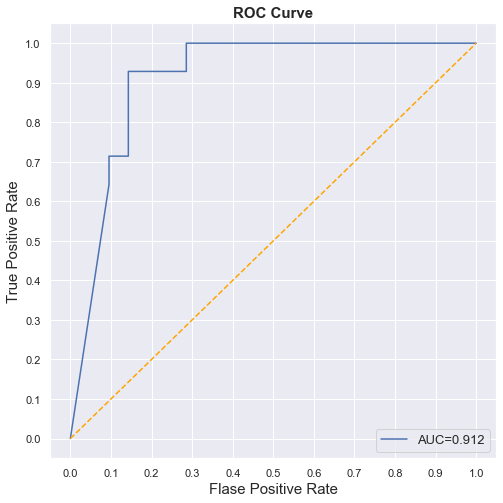

In [455]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_roc_auc(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(8,8))

    plt.plot(fpr, tpr, label="AUC={:.3f}".format(roc_auc))
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()
    
plot_roc_auc(y_test, y_score)

In [456]:
df.loc[df_test.index]['compound_name'][df['y']==1].values, df.loc[df_test.index]['compound_name'][df['y']==0].values

(array(['paclitaxel', 'vincristine', 'LTC4', 'Vemurafenib', 'Sildenafil',
        'Doxorubicin', 'Sulfinpyrazone',
        '\ufeffGlycolithocholate-3-sulfate', '\ufeffTaurocholate',
        '\ufeff16alpha,17beta-Estriol 3-(beta-d-glucuronide) (Estriol 3-glucuronide)',
        '5-azacytidine', "ddC (2'-3'-dideoxycytidine)", 'PMEA',
        'masitinib'], dtype=object),
 array(['\ufeffProbenecid', 'dasatinib', '5-dFUrd', '5-FdUrd',
        "CdA (2'-chloro-2'-deoxyadenosine)", 'phomopsin A', 'MST997',
        'Siphonellinol D', 'mek162', 'WHI‐P154', 'CCTA-2', 'CCTA-3',
        'CCTA-9', 'CCTA-13', 'CCTA-20', 'CCTA-32', 'CCTA-33', 'CCTA-37',
        'CCTA-42', 'CCTA-45', 'CCTA-47'], dtype=object))

In [306]:
homology_model_pos_score = [-9.095, -6.243, -10.088, -7.180, -5.867, 
                            -7.404, -7.338, 
                            -5.667, -7.239, 
                            -5.470, -5.142, 
                            -4.959, -5.151, -7.255] 

homology_model_neg_score = [-4.661, -6.306, -6.572, -5.901, 
                            -6.293, -5.772, -7.159, 
                            -4.502, -6.945, -5.717, -5.471, -5.900, 
                            -6.527, -6.689, -6.437, -6.600, -6.806, -6.248, 
                            -6.419, -6.381, -6.508]
homology_model_pos_y = [1] * len(homology_model_pos_score)
homology_model_neg_y = [0] * len(homology_model_neg_score)

benchmark_score = homology_model_pos_score + homology_model_neg_score

benchmark_proba_min = np.array(benchmark_score) / np.min(benchmark_score)


benchmark_test = homology_model_pos_y + homology_model_neg_y

def moving_accuracy(docking_score, y_test, threshold):
    '''
    Calculate accuracy of homology model docking by setting a threhold
    1: score <= threshold
    2: score > threhold
    '''
    benchmark_pred = []
    for i in range(len(docking_score)):
        benchmark_pred.append(1 if docking_score[i] <= threshold else 0)
    return benchmark_pred

def range_threshold(docking_score, y_test, start, end, step):
    pred_multiple_thresholds = dict()
    for thres in np.arange(start, end, step):
        pred_multiple_thresholds[thres] = moving_accuracy(docking_score, y_test, thres)
    return pred_multiple_thresholds

pred_multiple_thresholds = range_threshold(benchmark_score, y_test, -8.000, -5.500, 0.5)

benchmark_proba_list = [
    benchmark_proba_min,
    benchmark_proba_15,
    benchmark_proba_20,
    benchmark_proba_25,
    benchmark_proba_30
]

print(pred_multiple_thresholds)
print(benchmark_proba_list)

{-8.0: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -7.5: [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -7.0: [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -6.5: [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1], -6.0: [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[array([0.90156622, 0.61885408, 1.        , 0.71173672, 0.58158208,
       0.73394132, 0.72739889, 0.56175654, 0.71758525, 0.54222839,
       0.50971451, 0.49157415, 0.51060666, 0.71917129, 0.4620341 ,
       0.62509913, 0.65146709, 0.58495242, 0.62381047, 0.57216495,
       0.70965504, 0.4462728 , 0.68844171, 0.56671293, 0.54232752,
       0.58485329, 0.64700634, 0.66306503, 0.63808485, 0.65424266,
       0.67466297, 0.61934972, 

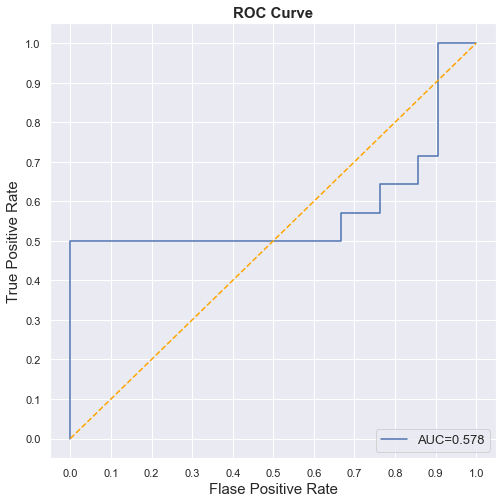

In [457]:
plot_roc_auc(benchmark_test, benchmark_proba)

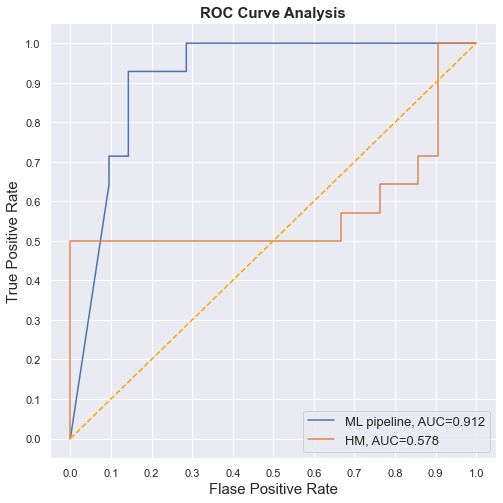

In [458]:
def plot_multiple_roc_auc(probas_dict, y_test):
    
    result_table = pd.DataFrame(columns=['name', 'fpr','tpr','auc'])

    for k, proba in probas_dict.items():
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_scores = auc(fpr, tpr)
        
#         print("proba:", proba)
#         print("fpr: ", fpr)
#         print("tpr: ", tpr)
#         print("roc_auc: ", roc_auc)
#         print("name: ", k)

        result_table = result_table.append({'name':k,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':roc_scores}, ignore_index=True)
    
    # Set name of the classifiers as index labels
    result_table.set_index('name', inplace=True)
#     print(result_table)
    
    fig = plt.figure(figsize=(8, 8))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label=f"{i}, AUC={result_table.loc[i]['auc']:.3f}")

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

probas_dict = {
    'ML pipeline': y_score,
    'HM': benchmark_proba
}
plot_multiple_roc_auc(probas_dict, y_test)

In [346]:
def get_scoring_all(y_true, y_score, y_pred):
    return {
        'stats': {
            'tp': tp(y_true, y_pred),
            'fp': fp(y_true, y_pred),
            'tn': tn(y_true, y_pred),
            'fn': fn(y_true, y_pred),
        },
        'score': {
            'roc_auc': roc_auc(y_true, y_score),
            'accuracy': accuracy(y_true, y_pred),
            'precision': precision(y_true, y_pred),
            'recall': recall(y_true, y_pred),
            'f1': f1(y_true, y_pred)
        }
    }

print('ML')
print(get_scoring_all(y_test, y_score, y_pred))

for thresh, y_pred in pred_multiple_thresholds.items():
    print(thresh)
    score = get_scoring_all(y_test, benchmark_proba_min, y_pred)
    print(score)

ML
{'stats': {'tp': 13.0, 'fp': 4.0, 'tn': 17.0, 'fn': 1.0}, 'score': {'roc_auc': 0.9421768707482994, 'accuracy': 0.8571428571428571, 'precision': 0.7647058823529411, 'recall': 0.9285714285714286, 'f1': 0.8387096774193549}}
-8.0
{'stats': {'tp': 2.0, 'fp': 0.0, 'tn': 21.0, 'fn': 12.0}, 'score': {'roc_auc': 0.5782312925170068, 'accuracy': 0.6571428571428571, 'precision': 1.0, 'recall': 0.14285714285714285, 'f1': 0.25}}
-7.5
{'stats': {'tp': 2.0, 'fp': 0.0, 'tn': 21.0, 'fn': 12.0}, 'score': {'roc_auc': 0.5782312925170068, 'accuracy': 0.6571428571428571, 'precision': 1.0, 'recall': 0.14285714285714285, 'f1': 0.25}}
-7.0
{'stats': {'tp': 7.0, 'fp': 1.0, 'tn': 20.0, 'fn': 7.0}, 'score': {'roc_auc': 0.5782312925170068, 'accuracy': 0.7714285714285715, 'precision': 0.875, 'recall': 0.5, 'f1': 0.6363636363636364}}
-6.5
{'stats': {'tp': 7.0, 'fp': 8.0, 'tn': 13.0, 'fn': 7.0}, 'score': {'roc_auc': 0.5782312925170068, 'accuracy': 0.5714285714285714, 'precision': 0.4666666666666667, 'recall': 0.5, 

# Predict ZZ compounds

In [348]:
df_zz = pd.read_csv('./data/featurized_zz.csv')
df_zz.head()

,compound_name,smiles,atomic_mass_high,atomic_mass_low,gasteiger_charge_high,gasteiger_charge_low,crippen_logp_high,crippen_logp_low,crippen_mr_high,crippen_mr_low,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,c13,COC1=CC(C2=NC(SCC#C)=NC(NNC(N)=S)=C2C#N)=CC(OC...,32.166572,10.055639,2.205262,-2.160132,2.417336,-2.343457,7.988932,0.324398,...,0,0,0,2,0,0,0,0,0,0
1,c387,CC1=CC=CC=C1NC2=C(C#N)C(C3=CC=CC=C3)=NC(SCC4=C...,35.495693,10.071002,2.174686,-2.136808,2.316090,-2.041472,7.979173,0.649210,...,0,0,1,4,0,0,0,0,0,0
2,c404,ClC1=CC=CC(NC2=C(C#N)C(C3=CC=C(C(C)C)C=C3)=NC(...,35.495693,9.992874,2.182345,-2.134840,2.322798,-2.364011,7.979180,-0.120225,...,0,0,1,4,0,0,0,0,0,0
3,c436,ClC1=CC=CC(NC(N=C(SCC(NC(NC2=CC=CC=N2)=O)=O)N=...,35.495693,10.052800,2.216401,-2.161742,2.421333,-2.352639,7.993460,-0.116949,...,0,0,0,4,0,0,0,0,0,0
4,c441,O=C(NC1=CC=CC=N1)NC(CSC2=NC(NC3=CC=C(Cl)C=C3)=...,35.495693,10.052809,2.216012,-2.161459,2.421120,-2.352638,7.993460,-0.116949,...,0,0,0,4,0,0,0,0,0,0


In [352]:
X_test_zz = df_zz.iloc[:, 2:]
y_pred_zz = clf_best.predict(X_test_zz)
y_score_zz = [score[1] for score in clf_best.predict_proba(X_test_zz)]
print([ele for ele in zip(y_pred_zz, y_score_zz)])
clf_best

[(1, 0.9999584055220166), (1, 0.9999473601045907), (1, 0.9999747915961241), (1, 0.9999797653798753), (1, 0.9999836739568816), (1, 0.999994102538399)]


Pipeline(steps=[('sclr', DummyScaler(scaler=MinMaxScaler())),
                ('clf',
                 MLPClassifier(alpha=0.1, hidden_layer_sizes=10,
                               solver='lbfgs'))])

In [410]:
# Ratio for ZZ

RATIO_exe = 0.55

chosen_idx_exe = np.random.choice(len(df), replace=False, size=int(RATIO_exe*(len(df))))
df_train_exe = df.iloc[chosen_idx_exe, 1:]
mask_exe = ~df.index.isin(df_train_exe.index)
df_test_exe = df.loc[mask_exe].iloc[:, 1:]

print(len(df_train_exe))
print(len(df_test_exe))

X_train_exe = df_train_exe.drop(['y', 'smiles'], axis=1).astype('float64')
y_train_exe = df_train_exe['y'].astype(int)

X_test_exe = df_test_exe.drop(['y', 'smiles'], axis=1).astype('float64')
y_test_exe = df_test_exe['y'].astype(int)

X_train_exe.shape, y_train_exe.shape, X_test_exe.shape, y_test_exe.shape

63
53


((63, 126), (63,), (53, 126), (53,))

In [411]:
pipeline_exe = Pipeline([("sclr", DummyScaler()), ("clf", DummyClassifier()),])
    
# Grid search
mscv_exe = GridSearchCV(
        pipeline,
        grid_light, 
        cv=StratifiedKFold(n_splits=5, shuffle=False),
        return_train_score=True,
        n_jobs=-1,
        verbose=10,
        refit="f1")

mscv_exe.fit(X_train_exe, y_train_exe)

def logging(model, path="./scores_zz.csv"):
    score_df = pd.DataFrame(model.cv_results_).T
    print(f"Cross-validation scores {score_df}")
    score_df.to_csv(path)
    
logging(mscv_exe)
    
clf_best_exe = mscv_exe.best_estimator_
clf_best_score_exe = mscv_exe.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0446s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    1.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.4s remaining:    0.3s


Cross-validation scores                                                                     0  \
mean_fit_time                                               0.0143873   
std_fit_time                                                0.0023983   
mean_score_time                                            0.00684943   
std_score_time                                             0.00217451   
param_clf                                       SVC(probability=True)   
param_sclr__scaler                                   StandardScaler()   
params              {'clf': SVC(probability=True), 'sclr__scaler':...   
split0_test_score                                            0.769231   
split1_test_score                                            0.769231   
split2_test_score                                            0.846154   
split3_test_score                                            0.666667   
split4_test_score                                            0.583333   
mean_test_score            

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished


In [412]:
X_test_zz = df_zz.iloc[:, 2:]
y_pred_zz = clf_best_exe.predict(X_test_zz)
y_score_zz = [score[1] for score in clf_best_exe.predict_proba(X_test_zz)]
print([ele for ele in zip(y_pred_zz, y_score_zz)])
clf_best_exe

[(0, 0.45), (1, 0.69), (1, 0.76), (1, 0.63), (1, 0.65), (1, 0.66)]


Pipeline(steps=[('sclr', DummyScaler(scaler=MinMaxScaler())),
                ('clf', RandomForestClassifier())])